In [8]:
import pandas as pd
import numpy as np
import math
import time
from geographiclib.geodesic import Geodesic
from haversine import haversine, Unit
from shapely.geometry import LineString, Point,MultiPoint
from tabulate import tabulate
from datetimerange import DateTimeRange

In [9]:
##  Defines distances from object, according to heading direction, defining safe rectangle [meters]
safe_dst = {"Tractor":[5,5,5,20], "Cow": [5,5,5,5]}

origin = (65,14)

vertical_line_threshold = 1000000

def line_eq_from_points (p1: Point, p2: Point):       ## returns tuple (m,q) for equation y = mx +q, if line is vertical returns (inf, x0) for equation x = x0
    if abs(p1.x-p2.x) < vertical_line_threshold:    ## check if line is not vertical
        m = (p1.y-p2.y)/(p1.x-p2.x)
        q = (p1.x*p2.y-p2.x*p1.y)/(p1.x-p2.x)
    else:
        m = float('inf')
        q = p1.x
    return line(m,q)

class line:     ## line object with equation y = mx + q
    def __init__(self,m,q):
        self.m = m
        self.q = q
    def __str__(self):
        return "Line with equation y = %fx + %f" % (self.m, self.q)

def intersection_between_lines (l1: line, l2: line):
    if l1.m != float('inf') and l2.m != float('inf'):
        a = np.array([[-l1.m,1],[-l2.m,1]])
        b = np.array([l1.q,l2.q])
        x = np.linalg.solve(a,b)
        return Point(x[0],x[1])
    elif l1.m == float('inf') and l2.m != float('inf'):
        return Point(l1.q, (l2.m*l1.q + l2.q))
    elif l2.m == float('inf') and l1.m != float('inf'):
        return Point(l2.q, (l1.m*l2.q + l1.q))
    else:
        return Point(float('inf'),float('inf'))

def cartesian_rotation(p: Point,angle):
    x_rotated, y_rotated = (p.x*math.cos(angle)-p.y*math.sin(angle),p.y*math.cos(angle)+p.x*math.sin(angle))
    return Point(x_rotated, y_rotated)

def heading_between_two_points(p1: Point, p2: Point):  ## p1 Current Point, p2 Previous Point
    if (p1.x - p2.x) != 0:
            h = math.atan((p1.y - p2.y)/(p1.x - p2.x))
    elif (p1.y - p2.y) > 0:
        h = 0
    else:
        h = math.pi/2
    return h

def get_relative_coordinates(origin_coordinates, coordinates):
    d = haversine(origin_coordinates,(coordinates), unit=Unit.METERS)
    b = Geodesic.WGS84.Inverse(origin_coordinates[0],origin_coordinates[1],coordinates[0],coordinates[0])['azi1']
    x_rel = d*math.sin(b)
    y_rel = d*math.cos(b)
    return Point(x_rel, y_rel)

class moving_object:
    def __init__(self, lat, lon, id, type):
        self.lat = lat
        self.lon = lon
        self.timestamp = time.time()
        self.type = type
        self.id = id
        self.xy = get_relative_coordinates(origin, (self.lat, self.lon))
        self.vertices = [Point(0,0),Point(0,0),Point(0,0),Point(0,0)]
        self.counter = 0
        self.xy = Point(0,0)
        pass

    def update_position(self,n_lat, n_lon):
        self.prev_lat = self.lat
        self.lat = n_lat
        self.prev_lon = self.lon
        self.lon = n_lon
        self.prev_timestamp = self.timestamp
        self.timestamp = time.time()     ## timestamps seconds
        distance = haversine((self.lat, self.lon),(self.prev_lat,self.prev_lon), unit=Unit.METERS)
        self.speed = distance / ((self.timestamp - self.prev_timestamp))        ##speed in m/s
        self.xy_prev = self.xy
        self.xy = get_relative_coordinates(origin, (self.lat, self.lon))
        self.heading = heading_between_two_points(self.xy, self.xy_prev)
        self.counter +=1
        pass

    def update_position_local(self,t_x, t_y):
        self.xy_prev = self.xy
        self.xy = Point(t_x, t_y)
        self.prev_timestamp = self.timestamp
        self.timestamp = time.time()     ## timestamps seconds
        distance = self.xy.distance(self.xy_prev)
        self.speed = distance / ((self.timestamp - self.prev_timestamp))        ##speed in m/s
        self.heading = heading_between_two_points(self.xy, self.xy_prev)
        self.counter +=1
        pass

    def update_safety_rectangle(self):
        vert = [Point(0,0),Point(0,0),Point(0,0),Point(0,0)]
        vert[0] = cartesian_rotation(Point(-safe_dst[self.type][1],safe_dst[self.type][0]),self.heading)
        vert[1] = cartesian_rotation(Point(-safe_dst[self.type][1],-safe_dst[self.type][2]),self.heading)
        vert[2] = cartesian_rotation(Point(safe_dst[self.type][3],-safe_dst[self.type][2]),self.heading)
        vert[3] = cartesian_rotation(Point(safe_dst[self.type][3],safe_dst[self.type][0]),self.heading)
        self.vertices = [Point(vert[i].x+self.xy.x,vert[i].y+self.xy.y) for i in range(4)]
        pass

In [10]:
##  Collision Avoidance function

def collision_state(obj_1: moving_object, obj_2: moving_object):

    if obj_1.counter == 0 or obj_2.counter == 0:
        return "Impossible to calculate collision time without previous positions"

    ## compute directional lines
    r1_l = line_eq_from_points(obj_1.vertices[0], obj_1.vertices[3])
    r1_r = line_eq_from_points(obj_1.vertices[1], obj_1.vertices[2])
    r2_l = line_eq_from_points(obj_2.vertices[0], obj_2.vertices[3])
    r2_r = line_eq_from_points(obj_2.vertices[1], obj_2.vertices[2])

    ## compute intersection points (c_xy with x side from obj1 and y side form obj2)
    c_ll = intersection_between_lines(r1_l, r2_l)
    c_lr = intersection_between_lines(r1_l, r2_r)
    c_rl = intersection_between_lines(r1_r, r2_l)
    c_rr = intersection_between_lines(r1_r, r2_r)
    c_list = [c_ll,c_lr,c_rl,c_rr]
    
   # collision_heading_1 = math.atan((c_ll.y - obj_1.vertices[0].y)/(c_ll.x - obj_1.vertices[0].x))
    if (c_ll.x - obj_1.vertices[0].x) != 0:
            collision_heading_1 = math.atan((c_ll.y - obj_1.vertices[0].y)/(c_ll.x - obj_1.vertices[0].x))
    elif (c_ll.y - obj_1.vertices[0].y) > 0:
        collision_heading_1 = 0
    else:
        collision_heading_1 = math.pi/2

    print(collision_heading_1,obj_1.heading)

    #collision_heading_2 = math.acos((c_ll.x - obj_2.vertices[0].x)/c_ll.distance(obj_2.vertices[0]))
    if (c_ll.x - obj_2.vertices[0].x) != 0:
            collision_heading_2 = math.atan((c_ll.y - obj_2.vertices[0].y)/(c_ll.x - obj_2.vertices[0].x))
    elif (c_ll.y - obj_2.vertices[0].y) > 0:
        collision_heading_2 = 0
    else:
        collision_heading_2 = math.pi/2

    print(collision_heading_2,obj_2.heading)

    if collision_heading_1 != obj_1.heading or collision_heading_2 != obj_2.heading:
         print("No collision")

    collision_time_table_1 = np.zeros((4,4))
    collision_time_table_2 = np.zeros((4,4))

    for i in range(4):
        for j in range(4):
            collision_time_table_1[i,j] = obj_1.vertices[i].distance(c_list[j])/obj_1.speed
            collision_time_table_2[i,j] = obj_2.vertices[i].distance(c_list[j])/obj_2.speed

    occupation_timedelta_1 = DateTimeRange(collision_time_table_1.min(),collision_time_table_1.max())
    occupation_timedelta_2 = DateTimeRange(collision_time_table_2.min(),collision_time_table_2.max())
    collision_time = max(collision_time_table_1.min(),collision_time_table_2.min())
    if occupation_timedelta_1.is_intersection(occupation_timedelta_2):
        print("collision in %f seconds" % collision_time)
    
    return [c_list, collision_time_table_1, collision_time_table_2,occupation_timedelta_1,occupation_timedelta_2]
    

In [11]:
object_1 = moving_object(0,0,0,type="Tractor")
object_2 = moving_object(0,0,1,type="Cow")
time.sleep(0.001)
object_2.update_position_local(100,0)
time.sleep(1)
object_1.update_position_local(5,5)
object_2.update_position_local(95,5)
print(object_1.speed)
print(object_1.timestamp - object_1.prev_timestamp)
print((object_1.heading*(180/math.pi)),(object_2.heading*(180/math.pi)))

7.020977089205084
1.0071344375610352
45.0 -45.0


In [12]:
object_1.update_safety_rectangle()
object_2.update_safety_rectangle()


In [13]:
res = collision_state(object_1,object_2)
cl = res[0]
ct1 = res[1]
ct2 = res[2]
otd1 = res[3]
otd2 = res[4]

0.7853981633974483 0.7853981633974483
-0.7853981633974483 -0.7853981633974483
collision in 7.601977 seconds


In [17]:

g = MultiPoint(object_1.vertices+[object_1.xy]+object_2.vertices+[object_2.xy]+cl)


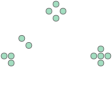

In [20]:
display(g)